# Neural Style Transfer Demo

This demo will show you how to apply style of one image to another image by using a deep learning technique called neural style transfer. This technique is described in [this paper](https://arxiv.org/pdf/1508.06576.pdf) by Leon A. Gatys.

# Downloading images

In [1]:
import wget
import os

image_links = [
    'https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
]

renames = [
    'green_turtle.jpg',
    'the_great_wave_off_kanagawa.jpg',
    'starry_night.jpg'
]

image_dir = './images/'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)

if len(os.listdir(image_dir)) <= 10:
    for i, link in enumerate(image_links):
        wget.download(link, image_dir + renames[i])

In [2]:
# List of images
os.listdir(image_dir)

['generated_images',
 'green_turtle.jpg',
 'starry_night.jpg',
 'the_great_wave_off_kanagawa.jpg']

# Importing libraries

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import concat, convert_to_tensor, GradientTape, transpose, reshape, shape, matmul, Variable, zeros
from tensorflow.math import reduce_mean
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Setting up the model

In [4]:
model = VGG19(include_top=False, # not including fully connected layers
              weights = 'imagenet',
              input_shape= (512, 512, 3),
              pooling = 'avg' # replacing max-pooling with avg pooling
             )

In [5]:
# Checking model layers
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

# Preprocessing images

In [6]:
style_path = './images/the_great_wave_off_kanagawa.jpg'
content_path = './images/green_turtle.jpg'

In [7]:
def image_to_tensor(img_path):
    """
    Resizes input image and then converts into a tensor
    """
    # load img and resize to 512x512
    img = load_img(img_path, target_size = (512, 512))
    
    # convert to numpy array
    img = img_to_array(img)
    
    # reshape data for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    
    # return a tensor
    return convert_to_tensor(img)

In [8]:
# Converting style and content images into tensors for modeling
style_tensor = image_to_tensor(style_path)
content_tensor = image_to_tensor(content_path)

# Starting with the original content image
generated_tensor = content_tensor

# Visualizing inputs

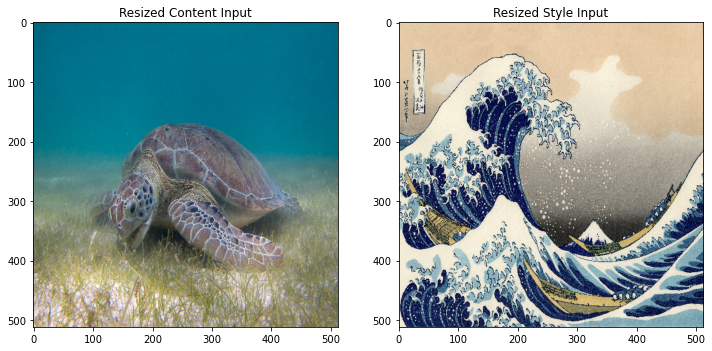

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
# np.squeeze to remove batch dimension
plt.imshow(np.squeeze(content_tensor, axis=0).astype('uint8'))
plt.title('Resized Content Input')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(style_tensor, axis=0).astype('uint8'))
plt.title('Resized Style Input');

# Extracting features

In [10]:
# layer name to layer output dictionary
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# new model that returns outputs
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [11]:
layer_names = [layer.name for layer in model.layers]

In [12]:
layer_names

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool',
 'global_average_pooling2d']

In [13]:
content_layer = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

In [14]:
style = feature_extractor(style_tensor)
content = feature_extractor(content_tensor)
generated = feature_extractor(generated_tensor)

# Visualizing the outputs of style image

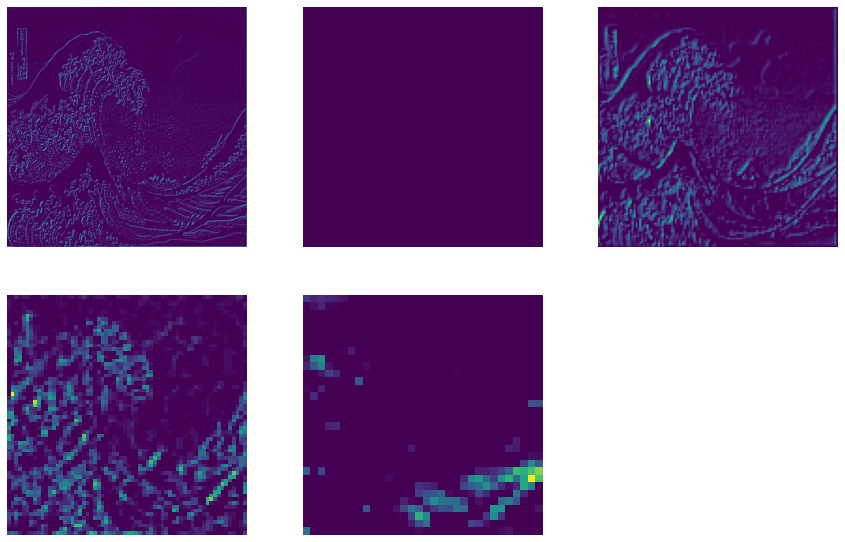

In [15]:
plt.figure(figsize=(15,15))

for i, layer in enumerate(style_layers):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(style[layer].numpy()[0,:,:,0])
    ax.axis('off')

# Visualizing the outputs of content image

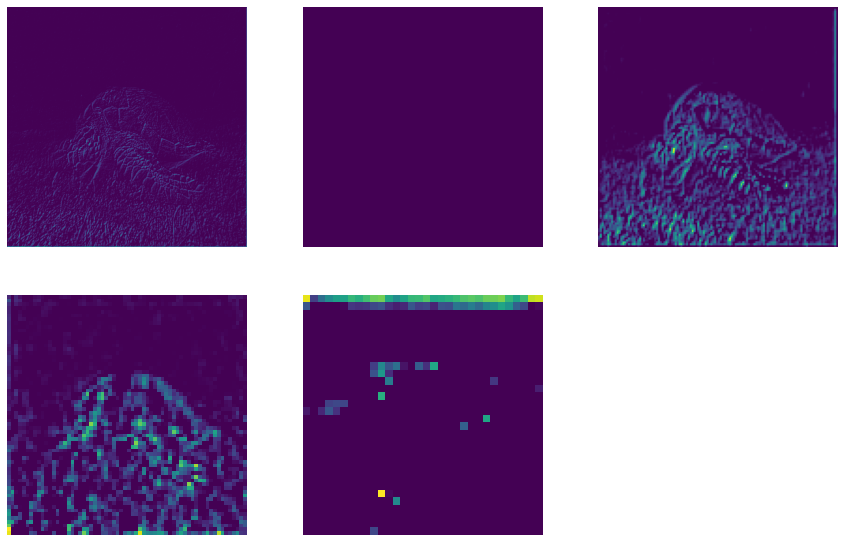

In [16]:
plt.figure(figsize=(15,15))

for i, layer in enumerate(style_layers):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(content[layer].numpy()[0,:,:,0])
    ax.axis('off')

# Defining Content Loss

> "So let ~p and ~x be the original image and the image that is generated and P and F their respective feature representation in layer l. We then define the squared-error loss between the two feature representations:"

![content_loss](https://i.imgur.com/61YuX36.png)

In [17]:
def calc_content_loss(F, P):
    L = zeros(shape=())
    L += 0.5 * reduce_mean((F-P)**2).numpy()
    return L

In [18]:
# Content loss calculation
original_image = content_tensor
generated_image = np.zeros((1, 512, 512, 3))

input_tensor = concat([original_image, generated_image], axis=0)
features = feature_extractor(input_tensor)
F = features[content_layer[0]][0, :, :, :]
P = features[content_layer[0]][1, :, :, :]

calc_content_loss(F, P)

<tf.Tensor: shape=(), dtype=float32, numpy=683.6387>

In [19]:
# Content loss is 0 when F and P are the same
original_image = content_tensor
generated_image = content_tensor

input_tensor = concat([original_image, generated_image], axis=0)
features = feature_extractor(input_tensor)
F = features[content_layer[0]][0, :, :, :]
P = features[content_layer[0]][1, :, :, :]

calc_content_loss(F, P) # content loss is 0

<tf.Tensor: shape=(), dtype=float32, numpy=3.8499968e-13>

# Defining Style Loss

> "These feature correlations are given by the Gram matrix..."

![gram_matrix](https://i.imgur.com/hFBcnxi.png)

> "...generate a texture that matches the style of a given image ... by minimising the mean-squared distance between the entries of the Gram matrix from the original image and the Gram matrix of the image to be generated..."

![minimizing_mean_squared_distance](https://i.imgur.com/0Jqyr1t.png)

> "... and the total loss is:"

![total_loss](https://i.imgur.com/A5MCHSb.png)

> "where wl are weighting factors of the contribution of each layer to the total loss ... (wl = 1/5 in those layers)"

In [20]:
def gram_matrix(x):
    x = transpose(x, (2, 0, 1))
    features = reshape(x, (shape(x)[0], -1))
    gram = matmul(features, transpose(features))
    return gram

In [21]:
original_style = style['block5_conv1'][0,:, :]
generated_style = generated['block5_conv1'][0,:, :]

In [22]:
# Style loss calculation
G = gram_matrix(original_style)
A = gram_matrix(generated_style)
    
# Mean squared distance between the two matrices:
N = 32
M = 5000
    
E = (1/(4*(N**2)*(M**2)))*sum((G-A)**2) 
style_loss = reduce_mean((1/5)*E)
style_loss

<tf.Tensor: shape=(), dtype=float32, numpy=32922.215>

In [23]:
# Style loss is 0 when G and A are the same

G = gram_matrix(original_style)
A = gram_matrix(original_style)
    
# Mean squared distance between the two matrices:
N = 32
M = 5000
    
E = (1/(4*(N**2)*(M**2)))*sum((G-A)**2) 
style_loss = reduce_mean((1/5)*E)
style_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [24]:
def calc_total_loss(content_image, style_image, generated_image, alpha=0.2, beta=0.8):  
    total_loss = zeros(shape=())
    style_loss = zeros(shape=())
    
    input_tensor = concat([content_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)
    
    # Content loss:
    F = features[content_layer[0]][0,:,:,:]
    P = features[content_layer[0]][2,:,:,:]
    content_loss = calc_content_loss(F, P)

    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2,: ,: ,:]
        
        # Gram matrix:
        G = gram_matrix(style_features)
        A = gram_matrix(generated_features)
    
        # Mean squared distance between the two matrices:
        N = 32
        M = 5000
    
        E = (1/(4*(N**2)*(M**2)))*sum((G-A)**2) 
        style_loss += reduce_mean((1/5)*E)
        
    # Total loss:
    total_loss += alpha*content_loss + beta*style_loss
    return total_loss

In [25]:
style = image_to_tensor(style_path)
content = image_to_tensor(content_path)
generated = Variable(content)

calc_total_loss(content, style, generated)

<tf.Tensor: shape=(), dtype=float32, numpy=11198754000.0>

In [26]:
def compute_grads(content_array, style_array, generated_array):
    with GradientTape() as tape:
        loss = calc_total_loss(content_array, style_array, generated_array)
        grad = tape.gradient(loss, generated_array)
    return loss, grad

In [27]:
import re

def style_transfer(content_path, style_path, iterations=500, learning_rate=10, beta_1=0.9, epsilon=0.01):
    image_regex = re.compile(r'\./images/([a-z_]+)')
    content_name = image_regex.search(content_path).group(1)
    style_name = image_regex.search(style_path).group(1)
    
    try: 
        os.mkdir(f'./images/generated_images/{content_name}_{style_name}')
    except:
        pass
    
    # Converting images to tensors
    style = image_to_tensor(style_path)
    content = image_to_tensor(content_path)
    generated = Variable(content)

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, epsilon=epsilon, amsgrad=True, name='Adam')
    
    # Transferring style
    for i in range(iterations+1):
        loss, grads = compute_grads(content, style, generated)
        optimizer.apply_gradients([(grads, generated)])

        if i%100 == 0:
            print(f'Epoch: {i} \nTotal Loss: {loss.numpy()}')
            img = generated.numpy().squeeze()
            img = np.clip(img, 0, 255)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cv2.imwrite(f'./images/generated_images/{content_name}_{style_name}/{content_name}_{style_name}_{i}.jpg', img)

In [28]:
# style_transfer(content_path, style_path)

# Results

![](https://i.imgur.com/wcvfSPG.png)
<center><i>Green turtle and Van Gogh's Starry Night, 300 iterations</i></center>

![](https://i.imgur.com/bbeBe42.png)
<center><i>Green turtle and Hokusai's the Great Wave, 300 iterations</i></center>



Each image took about an hour to create with 500 iterations. For the reference, I have AMD Ryzen 5 3600 6-Core Processor.  The code above is CPU based, but there are ways to run neural style transfer off of GPU. If you want perform neural style transfer using GPU, you need to install PyCUDA. You can reference [this guide](http://bennycheung.github.io/deep-learning-on-windows-10) and [this repo by bennycheung](https://github.com/bennycheung/PyDeepStyle) and [this repo by titu1994](https://github.com/titu1994/Neural-Style-Transfer). 